In [1]:
from itertools import product, combinations
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import Parallel, delayed

from scipy.stats import gmean
import pymcdm as pm
from pymcdm.methods.comet_tools import triads_consistency
import pysensmcda
import pyfdm
import pickle

# Fuzzy ranking

In [2]:
def fuzzy_ranking(rankings, normalization_axis = None):
    """
    Generate fuzzy ranking matrix based on positional rankings.

    Parameters:
    ------------
    rankings : np.ndarray
        2D array with positional rankings, where each row represents a separate positional ranking of alternatives.

    normalization_axis : int, optional
        Specifies the type of fuzzy ranking representation. 
        If 0, it normalizes the obtained fuzzy rankings regarding values in columns (by distribution of positions for alternatives).
        If 1, it normalizes the obtained fuzzy rankings regarding values in rows (by positions in rankings).
        If None or not specified, it returns the default fuzzy ranking matrix without data normalization.

    Returns:
    ---------
    np.ndarray
        Fuzzy ranking matrix based on the specified normalization_axis. Each element represents the membership degree of alternatives and ranking positions.

    Example:
    ----------
    >>> rankings = np.array([
    ...     [1, 2, 3, 4, 5],
    ...     [2, 1, 5, 3, 4],
    ...     [4, 3, 2, 5, 1],
    ...     [3, 2, 1, 4, 5],
    ... ])
    >>> fuzzy_rank = fuzzy_ranking(rankings, normalization_axis=0)
    >>> print(fuzzy_rank)
    """

    ALT = len(rankings[0])

    columns_labels = [f'A{i+1}' for i in range(ALT)]

    pd_rank = pd.DataFrame(rankings, columns=columns_labels)
    rank_prob = np.zeros((ALT, ALT))  

    tie_positions = np.arange(1.5, ALT+1, 1)

    for row, col in enumerate(pd_rank.columns):
        for pos in range(ALT):
            rank_prob[pos, row] = len(pd_rank[pd_rank[col] == pos+1])

    # tie positions
    for row, col in enumerate(pd_rank.columns):
        for pos in tie_positions:
            count_tie = len(pd_rank[pd_rank[col] == pos])
            if count_tie == 0:
                continue
            # lower position
            rank_prob[int(np.floor(pos))-1, row] += count_tie/2
            # higher position
            rank_prob[int(np.ceil(pos))-1, row] += count_tie/2

    rank_prob = np.round(rank_prob / len(pd_rank), 4)
    rank_prob = pd.DataFrame(rank_prob, columns=columns_labels)

    if normalization_axis is None:
        return rank_prob.to_numpy()
    else:
        M = rank_prob.to_numpy()
        max_values = np.max(M, axis=normalization_axis)
        if normalization_axis == 0:
            FM = np.round(M / max_values, 4)
        else:
            FM = M.copy()
            for i in range(ALT):
                FM[i, :] = np.round(M[i, :] / max_values[i], 4)
        return FM

# Helper functions

In [3]:
def norm_weights(x):
    return x / x.sum()

def random_weights(n):
    w = (100 * np.random.rand(n)).astype('int')
    return norm_weights(w)
    
def mc_weights(ranking):
    w = (100 * np.random.rand(len(ranking))).astype('int')
    indices = np.argsort(ranking)
    w[indices] = np.sort(w)
    return norm_weights(w)

def modify_weights(weights, error):
    mask = np.random.rand(len(weights)) < 0.5
    sign = np.where(mask, 1, -1)
    delta = weights * error * sign
    return weights + delta

# Aggregation procedures

In [4]:
def fuzzy_ranking_aggregation(ranks):
    fuzzy_rank = fuzzy_ranking(ranks, normalization_axis=1)
    positions = np.arange(1, fuzzy_rank.shape[0]+1)
    weighted_rank = (fuzzy_rank.T * positions).T
    weighted_rank = np.sum(weighted_rank, axis=0)
    return pm.helpers.rankdata(weighted_rank)

def rank_position_aggregation(ranks):
    return pysensmcda.compromise.rank_position(ranks.T)

def borda_aggregation(ranks):
    return pysensmcda.compromise.borda(ranks.T)

def hq_aggregation(ranks):
    return pysensmcda.compromise.HQ_compromise(ranks.T)

def average_mean_aggregation(weights):
    return np.mean(weights, axis=0)

def geometric_mean_aggregation(weights):
    gweights = gmean(weights)
    return norm_weights(gweights)

def triangular_fuzzy_aggregation(weights):
    fuzzy_weights = np.vstack([np.min(weights, axis=0), np.array([np.round(gmean(weights[:, i]), 4) for i in range(weights.shape[1])]), np.max(weights, axis=0)])
    return pyfdm.methods.utils.defuzzifications.weighted_mean_defuzzification(fuzzy_weights)

# Evaluation metrics

In [5]:
def calculate_mae(weights1, weights2):
    return np.mean(np.abs(np.array(weights1) - np.array(weights2)))

def calculate_mse(weights1, weights2):
    return np.mean((np.array(weights1) - np.array(weights2)) ** 2)

# RANCOM method

In [6]:
class RANCOM:
    POSSIBLE_GRADES = [0, 0.5, 1]
    
    def __init__(self, error_prob):
        self.error_prob = error_prob
    
    def __call__(self, ranking):
        ranking = np.array(ranking)
        mac = self.build_mac(ranking)
        scw = np.sum(mac, axis=1)
        
        return norm_weights(scw)
    
    def __repr__(self):
        return f'RANCOM({self.error_prob})'
    
    def compare_values(self, c1, c2):
        if np.random.rand() < self.error_prob:
            return np.random.choice(RANCOM.POSSIBLE_GRADES)
        else:
            if c1 > c2:
                return 1
            if c1 == c2:
                return 0.5
        return 0

    def build_mac(self, ranking):
        co = np.array(list(ranking))

        mac = np.diag(np.ones(co.shape[0]) * 0.5)
        for i in range(mac.shape[0]):
            for j in range(i+1, mac.shape[1]):
                v = self.compare_values(co[i], co[j])
                mac[i, j] = v
                mac[j, i] = 1 - v
        return mac


# Simulation experiment

In [7]:
def experiment(experts, diff_opinion, simulations, crit_nums, agg_procedures):

    results = []
    for crit_n in crit_nums:

        wsc = []
        rw = np.zeros((simulations, len(agg_procedures.keys()), len(agg_procedures.keys())), dtype='float')
        ws = np.zeros((simulations, len(agg_procedures.keys()), len(agg_procedures.keys())), dtype='float')
        mae = np.zeros((simulations*experts, len(agg_procedures.keys())), dtype='float')
        mse = np.zeros((simulations*experts, len(agg_procedures.keys())), dtype='float')
        topsis = pm.methods.TOPSIS()

        for sim in range(simulations):
            try:

                ref_weights = random_weights(crit_n)
                dm = np.random.random((10, crit_n))
                types = np.random.choice([-1, 1], crit_n)

                group_weights = np.zeros((experts, crit_n))
                group_ranks = np.zeros((experts, crit_n))
                for expert in range(experts):
                    random_err = np.random.uniform(0, diff_opinion)
                    modified_weights = modify_weights(ref_weights, random_err)
                    weights_rank = pm.helpers.rrankdata(modified_weights)
                    
                    rancom = RANCOM(0)
                    rancom_weights = rancom(weights_rank)

                    group_weights[expert, :] = rancom_weights
                    group_ranks[expert, :] = weights_rank

                for w1 in group_weights:
                    for w2 in group_weights:
                        wsc.append(pm.correlations.wsc(w1, w2))

                temp_ranks = []
                group_agg_weights = np.zeros((len(agg_procedures.keys()), crit_n))
                for idx, f in enumerate(agg_procedures.values()):
                    if idx < 3:
                        agg_ranking = f(group_ranks)
                        agg_weights = rancom(agg_ranking)
                    else:
                        agg_weights = f(group_weights)
                    group_agg_weights[idx, :] = agg_weights

                    for weights_idx, expert_weights in enumerate(group_weights):

                        arr_idx = sim * experts + weights_idx 
                        mae[arr_idx, idx] = calculate_mae(expert_weights, agg_weights)           
                        mse[arr_idx, idx] = calculate_mse(expert_weights, agg_weights)               

                    pref = topsis(dm, agg_weights, types)
                    pref = np.nan_to_num(pref, nan=0)
                    rank = topsis.rank(pref)
                    temp_ranks.append(rank)
                
                temp_rw = []
                temp_ws = []
                for idx1 in range(len(agg_procedures.keys())):
                    temp_row = []
                    temp_row_ws = []
                    for idx2 in range(len(agg_procedures.keys())):
                        temp_row.append(pm.correlations.rw(temp_ranks[idx1], temp_ranks[idx2]))
                        temp_row_ws.append(pm.correlations.ws(temp_ranks[idx1], temp_ranks[idx2]))
                    temp_rw.append(temp_row)
                    temp_ws.append(temp_row_ws)
                
                rw[sim] = temp_rw
                ws[sim] = temp_ws
            except:
                continue

               # Remove rows containing only zeros
        non_zero_indices = np.where(np.any(np.any(rw, axis=2), axis=1))[0]
        rw = rw[non_zero_indices]
        ws = ws[non_zero_indices]
        
        # results.append([wsc, rw, ws, mae, mse])
        results.append([wsc, np.mean(rw, axis=0), np.mean(ws, axis=0), mae, mse])
    return results

# Visualization methods

In [8]:
def heatmap(matrix: np.ndarray, 
                title: str = "Fuzzy Ranking Matrix",
                xlabel: str = "Alternatives",
                ylabel: str = "Positions",
                cmap: str | list = "Blues",
                annotate: bool = True,
                fmt: str = ".2f",
                linewidths: float = .5,
                cbar_kwargs: dict = {'label': 'Membership Degree'},
                figsize: tuple = (8, 6),
                label_fontsize: int = 10,
                title_fontsize: int = 12,
                cbar_title_fontsize: int = 10,
                ticks_labels_fontsize: int = 8,
                ax: plt.Axes = None) -> plt.Axes:
    """
    Visualize the fuzzy ranking matrix using a heatmap.

    Parameters:
    ------------
    matrix : np.ndarray
        2D matrix, for example, obtained from the 'fuzzy_ranking' function.

    title : str, optional
        Title for the visualization.

    xlabel : str, optional
        Label for the x-axis.

    ylabel : str, optional
        Label for the y-axis.

    cmap : str or Colormap, optional
        Colormap for the heatmap.

    annotate : bool, optional
        If True, write the data values in each cell.

    fmt : str, optional
        String formatting code to use when adding annotations.

    linewidths : float, optional
        Width of the lines that will divide each cell.

    cbar_kwargs : dict, optional
        Additional keyword arguments for the colorbar.

    figsize : tuple, optional
        Figure size (width, height) in inches.

    label_fontsize : int, optional
        Font size for axis labels.

    title_fontsize : int, optional
        Font size for the title.

    cbar_title_fontsize : int, optional
        Font size for the colorbar title.
    
    ticks_labels_fontsize : int, optional
        Font size for the xticks and yticks labels.

    ax : plt.Axes, optional
        The axes on which to draw the heatmap. If not provided, a new figure will be created.

    Returns:
    ---------
    plt.Axes

    Examples:
    ----------
    >>> rankings = np.array([
    ...     [1, 2, 3, 4, 5],
    ...     [2, 1, 5, 3, 4],
    ...     [4, 3, 2, 5, 1],
    ...     [3, 2, 1, 4, 5],
    ... ])
    >>> fuzzy_rank = fuzzy_ranking(rankings, normalization_axis=0)
    >>> heatmap(fuzzy_rank, title="Fuzzy Ranking Matrix", figsize=(10, 8))

    """
    
    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.gca()
    else:
        ax = ax

    sns.heatmap(matrix, cmap=cmap, annot=annotate, fmt=fmt, linewidths=linewidths, cbar_kws=cbar_kwargs, ax=ax, annot_kws={'fontsize': 14})
    ax.figure.axes[-1].yaxis.label.set_size(cbar_title_fontsize)
    ax.set_title(title, fontsize=title_fontsize)
    x = np.arange(0, matrix.shape[0])
    ax.set_xticks(x+0.5, [f'$A_{{{i+1}}}$' for i in range(len(x))], fontsize=ticks_labels_fontsize)
    ax.set_yticks(x+0.5, [f'${i+1}$' for i in range(len(x))], fontsize=ticks_labels_fontsize)
    ax.set_xlabel(xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)

    return ax

In [9]:
def weights_boxplot(corr, crits, experts, diffs):
    
    plt.rcParams['figure.figsize'] = (8, 4)
    sns.boxenplot(corr, color='dodgerblue')
    x = crits - np.min(crits)
    plt.xticks(x, crits, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='both', color='grey', linestyle='--', alpha=0.7)
    plt.title(f'Correlation of weights values for {experts} experts ($\epsilon = {diffs}$)', fontsize=16)
    plt.xlabel('No. of criteria', fontsize=14)
    plt.ylabel('Weights similarity coefficient', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'img/weights_boxplot_{experts}_{diffs}.pdf')
    plt.show()


def rank_weights_boxplot(corr, crits, experts, diffs):
    plt.rcParams['figure.figsize'] = (8, 4)
    sns.boxenplot(corr, color='limegreen')
    plt.grid(axis='both', color='grey', linestyle='--', alpha=0.7)
    x = crits - np.min(crits)
    plt.xticks(x, crits, fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(f'Correlation of weights ranking for {experts} experts ($\epsilon = {diffs}$)', fontsize=16)
    plt.xlabel('No. of criteria', fontsize=14)
    plt.ylabel('$WS$ correlation', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'img/rank_weights_boxplot_{experts}_{diffs}.pdf')
    plt.show()

def corr_weights_heatmap(corr, agg_procedures, experts, diffs):
    plt.rcParams['figure.figsize'] = (14, 14)
    heatmap(corr, '', cbar_kwargs={'label': 'Weights similarity coefficient'}, cbar_title_fontsize=14)
    x = np.arange(0, len(agg_procedures.keys()))+0.5
    keys = list(agg_procedures.keys())
    plt.title(f'Correlation of aggregated weights for {experts} experts ($\epsilon = {diffs}$)', fontsize=14)
    plt.xticks(x, keys, fontsize=12)
    plt.yticks(x, keys, fontsize=12)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.savefig(f'img/corr_weights_heatmap_{experts}_{diffs}.pdf')
    plt.show()

def corr_ranks_heatmap(corr, agg_procedures, label, experts, diffs):
    plt.rcParams['figure.figsize'] = (14, 14)
    heatmap(corr, '', cbar_kwargs={'label': label}, cbar_title_fontsize=14)
    x = np.arange(0, len(agg_procedures.keys()))+0.5
    keys = list(agg_procedures.keys())
    plt.title(f'Correlation of TOPSIS rankings for {experts} experts ($\epsilon = {diffs}$)', fontsize=14)
    plt.xticks(x, keys, fontsize=12)
    plt.yticks(x, keys, fontsize=12)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.savefig(f'img/corr_ranks_heatmap_{experts}_{diffs}.pdf')
    plt.show()

def errorbar_plot(values, crit_nums, title, experts, diff, measure):
    mean_vals = np.mean(values, axis=1)
    std_vals = np.std(values, axis=1)

    step = 0.14
    plt.rcParams['figure.figsize'] = (16, 4)
    for i in range(len(mean_vals[0])):
        lower_limit = std_vals[:, i]
        lower_limit = np.array([lower_limit[k] if mean_vals[k, i] - std_vals[k, i] >= 0 else mean_vals[k, i] for k in range(len(lower_limit))])
        x = np.arange(len(mean_vals))
        plt.errorbar((x+step*i)-3*step+step/2, mean_vals[:, i], yerr=[lower_limit, std_vals[:, i]], fmt='o', capsize=5, label=list(agg_procedures.keys())[i].replace('\n', ' '))
    plt.xticks(range(len(mean_vals)), crit_nums, fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('No. of criteria', fontsize=18)
    plt.ylabel(title, fontsize=18)
    plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                    mode="expand", borderaxespad=0, ncol=6, fontsize=16)
    plt.grid(axis='both', linestyle='--', alpha=0.7, color='grey')
    plt.title(f'{experts} experts ($\epsilon = {diff}$)', y=0.90, fontsize=16)
    plt.tight_layout()
    plt.savefig(f'img/{measure}_{experts}_{diff}.pdf')
    plt.show()



In [10]:
agg_procedures = {
    'Fuzzy\nranking': fuzzy_ranking_aggregation,
    'Borda': borda_aggregation,
    'Rank\nposition': rank_position_aggregation,
    'Average\nmean': average_mean_aggregation,
    'Geometric\nmean': geometric_mean_aggregation,
    'Triangular\nFuzzy': triangular_fuzzy_aggregation 
}

In [11]:
np.random.seed(0)


# Simulation run

In [13]:
experts_num = [30, 40, 50]
diff_opinions_levels = [0.2, 0.5, 0.8]
SIM_RUNS = 1000
crit_nums = np.arange(4, 17)
pairs = product(experts_num, diff_opinions_levels)

results = Parallel(n_jobs=16, verbose=10)(delayed(experiment)
        (experts, diff_opinions, SIM_RUNS, crit_nums, agg_procedures) for experts, diff_opinions in pairs)

In [14]:
# Save results to a pickle file
with open('results.pkl', 'wb') as pickle_file:
    pickle.dump(results, pickle_file)

In [15]:
# Load data from the pickle file
with open('results.pkl', 'rb') as pickle_file:
    results = pickle.load(pickle_file)

In [16]:
plt.rcParams['axes.axisbelow'] = True

# Visualization generation

In [17]:
for i in range(9):
    pair = list(product(experts_num, diff_opinions_levels))[i]
    all_wsc = []
    for crit_idx in range(len(crit_nums)):
        wsc = results[i][crit_idx][0]
        all_wsc.append(wsc)
    
    df_wsc = pd.DataFrame(all_wsc)
    df_wsc.to_csv(f'./data/all_wsc_{i}.csv')
    
    weights_boxplot(all_wsc, crit_nums, pair[0], pair[1])

    all_rw = []
    all_ws = []
    for crit_idx in range(len(crit_nums)):
        all_rw.append(results[i][crit_idx][1].astype(float))
        all_ws.append(results[i][crit_idx][2].astype(float))

    corr_ranks_heatmap(np.mean(all_rw, axis=0), agg_procedures, '$r_W$ coefficient', pair[0], pair[1])
    corr_ranks_heatmap(np.mean(all_ws, axis=0), agg_procedures, '$WS$ coefficient', pair[0], pair[1])
    df_rw = pd.DataFrame(np.mean(all_rw, axis=0))
    df_rw.to_csv(f'./data/all_rw_{i}.csv')
    df_ws = pd.DataFrame(np.mean(all_ws, axis=0))
    df_ws.to_csv(f'./data/all_ws_{i}.csv')

    all_mae = []
    all_mse = []
    for crit_idx in range(len(crit_nums)):
        all_mae.append(results[i][crit_idx][3])
        all_mse.append(results[i][crit_idx][4])

    errorbar_plot(all_mae, crit_nums, 'Mean Absolute Error', pair[0], pair[1], 'mae')
    errorbar_plot(all_mse, crit_nums, 'Mean Squared Error', pair[0], pair[1], 'mse')
    np.save(f'all_mae_{i}.npy', np.array(all_mae))
    np.save(f'all_mse_{i}.npy', np.array(all_mse))

In [18]:
all_wsc = []
for crit_idx in range(len(crit_nums)):
    wsc = results[0][crit_idx][0]
    all_wsc.append(wsc)

In [19]:
weights_boxplot(all_wsc, crit_nums, 100, 0.2)


In [20]:
all_rw = []
all_ws = []
for crit_idx in range(len(crit_nums)):
    all_rw.extend(results[0][crit_idx][1].astype(float))
    all_ws.extend(results[0][crit_idx][2].astype(float))

In [21]:
corr_ranks_heatmap(np.mean(all_rw, axis=0), agg_procedures, '$r_W$ coefficient', 100, 0.2)

In [22]:
corr_ranks_heatmap(np.mean(all_ws, axis=0), agg_procedures, '$WS$ coefficient', 100, 0.2)

In [23]:
all_mae = []
all_mse = []
for crit_idx in range(len(crit_nums)):
    all_mae.append(results[0][crit_idx][3])
    all_mse.append(results[0][crit_idx][4])

In [24]:
mean_vals = np.mean(all_mae, axis=1)
std_vals = np.std(all_mae, axis=1)

step = 0.14
plt.rcParams['figure.figsize'] = (16, 4)
for i in range(len(mean_vals[0])):
    lower_limit = std_vals[:, i]
    lower_limit = np.array([lower_limit[k] if mean_vals[k, i] - std_vals[k, i] >= 0 else mean_vals[k, i] for k in range(len(lower_limit))])
    x = np.arange(len(mean_vals))
    plt.errorbar((x+step*i)-3*step+step/2, mean_vals[:, i], yerr=[lower_limit, std_vals[:, i]], fmt='o', capsize=5, label=list(agg_procedures.keys())[i].replace('\n', ' '))
plt.xticks(range(len(mean_vals)), crit_nums, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('No. of criteria', fontsize=16)
plt.ylabel('Mean Absolute Error', fontsize=16)
plt.legend(bbox_to_anchor=(0, 1.02, 1.0, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=6, fontsize=14)
plt.grid(axis='both', linestyle='--', alpha=0.7, color='grey')
plt.title(f'{30} experts ($\epsilon = {0.8}$)', y=0.90, fontsize=14)
plt.show()



In [25]:
mean_vals = np.mean(all_mse, axis=1)
std_vals = np.std(all_mse, axis=1)

step = 0.14
plt.rcParams['figure.figsize'] = (16, 4)
for i in range(len(mean_vals[0])):
    lower_limit = std_vals[:, i]
    lower_limit = np.array([lower_limit[k] if mean_vals[k, i] - std_vals[k, i] >= 0 else mean_vals[k, i] for k in range(len(lower_limit))])
    x = np.arange(len(mean_vals))
    plt.errorbar((x+step*i)-3*step+step/2, mean_vals[:, i], yerr=[lower_limit, std_vals[:, i]], fmt='o', capsize=5, label=list(agg_procedures.keys())[i].replace('\n', ' '))
plt.xticks(range(len(mean_vals)), crit_nums, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('No. of criteria', fontsize=16)
plt.ylabel('Mean Squared Error', fontsize=16)
plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=6, fontsize=14)
plt.grid(axis='both', linestyle='--', alpha=0.7, color='grey')
plt.title(f'{30} experts ($\epsilon = {0.8}$)', y=0.90, fontsize=14)
plt.show()


# Practical problem

Solar panels evaluation for PV farm

Practical problem

In [26]:
matrix = np.array([
    [42.8000, 10.8200, 21.4000, 213.8728, 358.9595, 10.1156],
    [40.9300, 9.8200, 19.3600, 193.2515, 105.1288, 11.0429],
    [40.2000, 9.9800, 19.3600, 193.2515, 139.2638, 11.0429],
    [40.6000, 10.4000, 19.6000, 196.4286, 100.5952, 10.7143],
    [41.2000, 10.3500, 19.7000, 196.5318, 230.0578, 10.4046],
    [43.3000, 10.5000, 20.8000, 208.0925, 344.7399, 10.4046],
    [41.6700, 10.0800, 19.4800, 188.6228, 107.7844, 11.1377],
    [40.5600, 9.9400, 19.0000, 189.3491, 167.7515, 11.0651],
    [40.6000, 10.0000, 19.3000, 192.7711, 124.6988, 11.3253],
    [40.5000, 10.2000, 19.2100, 191.6168, 153.2934, 11.3772],
    [43.3000, 9.5100, 19.5700, 189.3491, 133.8757, 11.3609],
    [45.0400, 10.5000, 20.1000, 200.0000, 156.8421, 10.2632],
    [44.0000, 10.3700, 20.6000, 205.7143, 228.0000, 11.1429],
    [44.3000, 10.2600, 20.9000, 208.5714, 170.8571, 11.1429],
    [44.2000, 10.5800, 21.4000, 214.2857, 194.2857, 11.1429],
    [40.6600, 10.5200, 19.0000, 189.9441, 135.3352, 11.1173],
    [45.4000, 10.2000, 19.7000, 196.7213, 133.8798, 10.9290],
    [41.0000, 10.9200, 18.7000, 187.5000, 135.0978, 11.0326],
    [48.0000, 10.8300, 21.0000, 211.0553, 248.7437, 10.3015],
    [49.8600, 10.3900, 20.2000, 201.4925, 101.9900, 10.2985],
    [48.3000, 9.6000, 20.5000, 204.4199, 218.2320, 11.6022],
    [47.6200, 9.6600, 18.6000, 186.5285, 133.1606, 11.2953],
    [49.6000, 10.6600, 20.4000, 206.4677, 101.9900, 10.9453],
    [46.8000, 9.5900, 17.8900, 179.2929, 81.3990, 11.3636],
    [51.2000, 10.2900, 20.2000, 201.9704, 111.8227, 11.2315],
    [48.9100, 10.2200, 20.2000, 202.0202, 143.8889, 11.6162],
    [48.9100, 10.7900, 20.3800, 203.9801, 137.3134, 11.4428],
    [49.1400, 11.0500, 19.1000, 190.9091, 131.5636, 10.6364],
    [49.0000, 10.2400, 19.9000, 198.0198, 176.2376, 11.6337],
    [49.3300, 10.8300, 20.1000, 200.9346, 111.3178, 11.6822]
])
criteria_types = np.array([-1, 1, 1, 1, -1, -1])

In [27]:
results = []
wsc = []
ws = []

experts = 50
diff_opinion = 0.8

topsis = pm.methods.TOPSIS()

ref_weights = pm.weights.entropy_weights(matrix)

crit_n = matrix.shape[1]
group_weights = np.zeros((experts, crit_n))
group_ranks = np.zeros((experts, crit_n))
for expert in range(experts):
    random_err = np.random.uniform(0, diff_opinion)
    modified_weights = modify_weights(ref_weights, random_err)
    weights_rank = pm.helpers.rrankdata(modified_weights)
    
    rancom = RANCOM(0)
    rancom_weights = rancom(weights_rank)

    group_weights[expert, :] = rancom_weights
    group_ranks[expert, :] = weights_rank

for w1 in group_weights:
    for w2 in group_weights:
        wsc.append(pm.correlations.wsc(w1, w2))

temp_ranks = []
group_agg_weights = np.zeros((len(agg_procedures.keys()), crit_n))
for idx, f in enumerate(agg_procedures.values()):
    if idx < 3:
        agg_ranking = f(group_ranks)
        agg_weights = rancom(agg_ranking)
    else:
        agg_weights = f(group_weights)
    group_agg_weights[idx, :] = agg_weights

    pref = topsis(matrix, agg_weights, criteria_types)
    pref = np.nan_to_num(pref, nan=0)
    rank = topsis.rank(pref)
    temp_ranks.append(rank)

for idx1 in range(len(agg_procedures.keys())):
    temp_row_ws = []
    for idx2 in range(len(agg_procedures.keys())):
        temp_row_ws.append(pm.correlations.rw(temp_ranks[idx1], temp_ranks[idx2]))
    ws.append(temp_row_ws)



In [28]:
print(np.round(np.mean(wsc), 2))
print(np.round(np.std(wsc), 2))

0.87
0.07


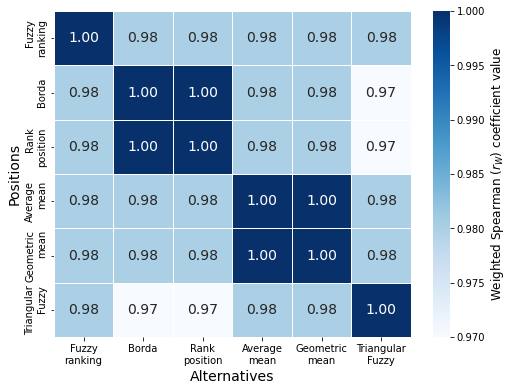

In [29]:
heatmap(np.round(np.array(ws), 2), title='', cbar_title_fontsize=12, cbar_kwargs={'label': "Weighted Spearman ($r_W$) coefficient value"}, ticks_labels_fontsize=12, label_fontsize=14)
keys = list(agg_procedures.keys())
x = np.arange(0, 6)+0.5
plt.xticks(x, keys, fontsize=10)
plt.yticks(x, keys, fontsize=10)
plt.savefig('img/panels_heatmap_rw.pdf')
plt.show()

In [31]:
temp_ranks

[array([ 1., 21., 19., 10.,  6.,  3., 20., 23., 26., 24., 28.,  4., 12.,
        11.,  9., 16., 15., 13.,  2.,  5., 27., 29.,  8., 30., 18., 22.,
        14.,  7., 25., 17.]),
 array([ 1., 24., 20., 10.,  9.,  3., 21., 25., 26., 23., 28.,  4., 13.,
        14.,  7., 16., 17., 11.,  2.,  6., 27., 29.,  8., 30., 18., 19.,
        12.,  5., 22., 15.]),
 array([ 1., 24., 20., 10.,  9.,  3., 21., 25., 26., 23., 28.,  4., 13.,
        14.,  7., 16., 17., 11.,  2.,  6., 27., 29.,  8., 30., 18., 19.,
        12.,  5., 22., 15.]),
 array([ 1., 24., 20., 12.,  8.,  3., 22., 27., 26., 23., 28.,  4., 11.,
        10.,  5., 18., 17., 14.,  2.,  6., 25., 29.,  7., 30., 16., 19.,
        13.,  9., 21., 15.]),
 array([ 1., 24., 20., 12.,  8.,  3., 22., 27., 26., 23., 28.,  4., 11.,
        10.,  5., 18., 17., 14.,  2.,  6., 25., 29.,  7., 30., 16., 19.,
        13.,  9., 21., 15.]),
 array([ 1., 23., 19.,  9.,  6.,  3., 20., 25., 24., 21., 28.,  4., 11.,
        10.,  5., 16., 17., 14.,  2.,  7., 27.,

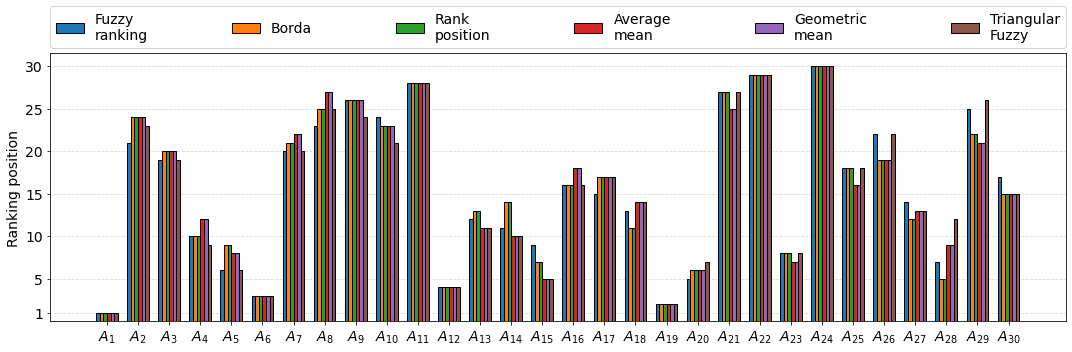

In [62]:
plt.rcParams['figure.figsize'] = (15, 5)
pm.visuals.ranking_bar(np.array(temp_ranks), labels=list(agg_procedures.keys()), legend_ncol=6)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=6, mode="expand", borderaxespad=0., fontsize=14)
plt.xticks(fontsize=14)
y = np.array([1, 5, 10, 15, 20, 25, 30])
plt.yticks(y, y, fontsize=14)
plt.ylabel('Ranking position', fontsize=14)
plt.tight_layout()
plt.savefig('img/ranking_bar.pdf')
plt.show()